In [1]:
import os
import cv2
import open3d as o3d
import torch
import json
import yaml
import numpy as np
import rosbag
import matplotlib.pyplot as plt
import data_conversion
import depth_anything_interface
import pcd_utils

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2024-10-16 09:36:45,199 - topics - topicmanager initialized


In [2]:
FRAME_INDEX = 0
GAP_INDEX = 10
MODEL_PATH = "/scratchdata/depth_anything_v2_metric_hypersim_vitl.pth"
model = depth_anything_interface.get_model("cuda", MODEL_PATH, model_type = "metric", encoder='vitl')

config = yaml.load(open("../config/gemini2L.yaml", "r"), Loader=yaml.FullLoader)

# Open bag file
bag_file_path = "/scratchdata/indoor_short.bag"
bag = rosbag.Bag(bag_file_path)

WARNING - 2024-10-16 09:36:45,838 - attention - xFormers not available
WARNING - 2024-10-16 09:36:45,839 - block - xFormers not available
INFO - 2024-10-16 09:36:45,864 - dinov2 - using MLP layer as FFN
/deep_stereo_ws/src/scripts/depth_anything_interface.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case wher

In [3]:
wait = 0
for topic, msg, t in bag.read_messages(topics=["/camera/color/camera_info"]):
    D = msg.D
    K = msg.K
    R = msg.R
    P = msg.P
    break

fx = P[0]
fy = P[5]
cx = P[2]
cy = P[6]

print(fx, fy, cx, cy)

306.4570007324219 306.4668884277344 319.01312255859375 197.51637268066406


In [4]:
cnt = 0 
for topic, msg, t in bag.read_messages(topics=["/camera/color/image_raw"]):
    if cnt ==  FRAME_INDEX:
        prev_img = data_conversion.topic_to_image(msg)
    if cnt == GAP_INDEX + FRAME_INDEX:
        new_img = data_conversion.topic_to_image(msg)
        break
    cnt+=1

cnt = 0 
for topic, msg, t in bag.read_messages(topics=["/camera/depth/image_raw"]):
    if cnt ==  FRAME_INDEX:
        prev_depth = data_conversion.topic_to_depth(msg, config["depth_anything_config"])
    if cnt == GAP_INDEX + FRAME_INDEX:
        new_depth = data_conversion.topic_to_depth(msg, config["depth_anything_config"])
        break
    cnt+=1


In [5]:
#prev_est_depth = prev_depth
#new_est_depth = new_depth 

prev_est_depth = model.infer_image(prev_img)
new_est_depth = model.infer_image(new_img)

In [6]:
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 1000,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

prev_gray = cv2.cvtColor(prev_img, cv2.COLOR_BGR2GRAY)
prev_point = cv2.goodFeaturesToTrack(prev_gray, mask = None, **feature_params)

new_gray = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
new_point, st, err = cv2.calcOpticalFlowPyrLK(prev_gray, new_gray, prev_point, None, **lk_params)

prev_point = prev_point[st==1]
new_point = new_point[st==1]

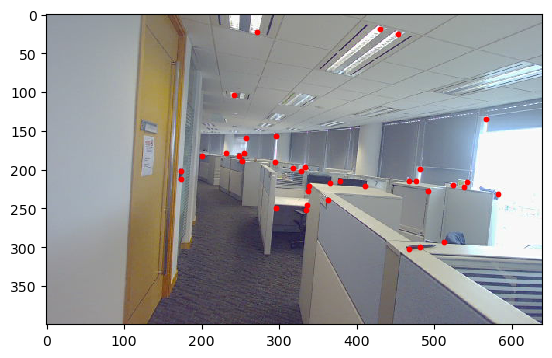

In [7]:
plt.imshow(prev_img)

# Draw prev_point

for i in range(prev_point.shape[0]):
    x, y = prev_point[i].ravel()
    plt.scatter(x, y, c='r', s=10)



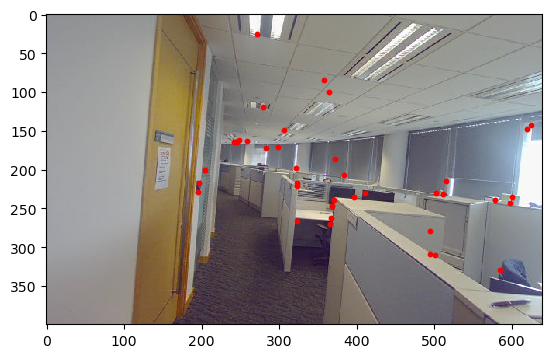

In [8]:
plt.imshow(new_img)

# Draw prev_point

for i in range(new_point.shape[0]):
    x, y = new_point[i].ravel()
    plt.scatter(x, y, c='r', s=10)


In [9]:
matching_depth1 = data_conversion.interpolate_depth(prev_est_depth, prev_point)
matching_depth2 = data_conversion.interpolate_depth(new_est_depth, new_point)

coord1 = np.zeros((len(matching_depth1), 3), dtype=np.float32)

coord1[:, 0] = (prev_point[:,0] - cx) * matching_depth1/ fx
coord1[:, 1] = (prev_point[:,1] - cy) * matching_depth1/ fy
coord1[:, 2] = matching_depth1

coord2 = np.zeros((len(matching_depth2), 3), dtype=np.float32)

coord2[:, 0] = (new_point[:,0] - cx) * matching_depth2/ fx
coord2[:, 1] = (new_point[:,1] - cy) * matching_depth2/ fy
coord2[:, 2] = matching_depth2

print(coord1.shape, coord2.shape)

(38, 3) (38, 3)


In [10]:
masks = (coord1[:, 2] > 0) & (coord2[:, 2] > 0)
coord1 = coord1[masks]
coord2 = coord2[masks]

print(coord1.shape)

(38, 3)


In [11]:
EPISON = 0.1
RANSAC_ITERATIONS = 500

best_tf = pcd_utils.pcd_matching_tf(coord1, coord2, EPISON, RANSAC_ITERATIONS, ransac_sample=5, verbose=True)
print(best_tf)

Inliers Ratio: 0.10526315789473684
[[ 0.99527031  0.00868816 -0.09675503 -0.03231418]
 [-0.01396563  0.99844319 -0.05400177  0.0787597 ]
 [ 0.09613524  0.05509759  0.99384218  0.37187129]
 [ 0.          0.          0.          1.02884254]]


In [12]:
prev_coord = data_conversion.depth_to_pcd(prev_est_depth,P) 
#prev_coord = prev_coord - mean_ori
#prev_coord = prev_coord / scale_ori

prev_coord = np.concatenate([prev_coord, np.ones((prev_coord.shape[0], 1))], axis=1)

prev_pcd = o3d.geometry.PointCloud()
prev_pcd.points = o3d.utility.Vector3dVector(prev_coord[:,:3]/prev_coord[:,3][:,None])
prev_pcd.colors = o3d.utility.Vector3dVector(prev_img.reshape(-1,3)/255.0)

#prev_pcd = prev_pcd.uniform_down_sample(every_k_points=4)
prev_pcd.voxel_down_sample(0.1)


new_coord = data_conversion.depth_to_pcd(new_est_depth,P)
#new_coord = new_coord - mean_new
#new_coord = new_coord / scale_new

new_coord = np.concatenate([new_coord, np.ones((new_coord.shape[0], 1))], axis=1)
new_coord = new_coord @ best_tf.T

new_pcd = o3d.geometry.PointCloud()
new_pcd.points = o3d.utility.Vector3dVector(new_coord[:,:3]/new_coord[:,3][:,None])
new_pcd.colors = o3d.utility.Vector3dVector(new_img.reshape(-1,3)/255.0)

#new_pcd = new_pcd.uniform_down_sample(every_k_points=4)
new_pcd.voxel_down_sample(0.1)

o3d.visualization.draw_geometries([prev_pcd, new_pcd])

In [13]:
voxel_radius = [0.04, 0.02, 0.01]
max_iter = [1000, 600, 280]
current_transformation = np.eye(4)


for scale in range(3):
    iter = max_iter[scale]
    radius = voxel_radius[scale]
    print([iter, radius, scale])

    print("3-1. Downsample with a voxel size %.2f" % radius)
    source_down = prev_pcd.voxel_down_sample(radius)
    target_down = new_pcd.voxel_down_sample(radius)

    print("3-2. Estimate normal.")
    source_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius * 2, max_nn=30))
    target_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius * 2, max_nn=30))

    print("3-3. Applying colored point cloud registration")
    result_icp = o3d.pipelines.registration.registration_icp(
        source_down, target_down, radius, current_transformation,
        o3d.pipelines.registration.TransformationEstimationPointToPoint())
    current_transformation = result_icp.transformation
    print(result_icp)

prev_pcd.transform(current_transformation)
print(current_transformation)


for scale in range(3):
    iter = max_iter[scale]
    radius = voxel_radius[scale]
    print([iter, radius, scale])

    print("3-1. Downsample with a voxel size %.2f" % radius)
    source_down = prev_pcd.voxel_down_sample(radius)
    target_down = new_pcd.voxel_down_sample(radius)

    print("3-2. Estimate normal.")
    source_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius * 2, max_nn=30))
    target_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius * 2, max_nn=30))

    print("3-3. Applying colored point cloud registration")
    result_icp = o3d.pipelines.registration.registration_icp(
        source_down, target_down, radius, current_transformation,
        o3d.pipelines.registration.TransformationEstimationPointToPlane())
    current_transformation = result_icp.transformation
    print(result_icp)

prev_pcd.transform(current_transformation)

o3d.visualization.draw_geometries([prev_pcd, new_pcd])

[1000, 0.04, 0]
3-1. Downsample with a voxel size 0.04
3-2. Estimate normal.
3-3. Applying colored point cloud registration
RegistrationResult with fitness=3.320435e-01, inlier_rmse=2.623138e-02, and correspondence_set size of 33381
Access transformation to get result.
[600, 0.02, 1]
3-1. Downsample with a voxel size 0.02
3-2. Estimate normal.
3-3. Applying colored point cloud registration
RegistrationResult with fitness=1.954601e-01, inlier_rmse=1.303748e-02, and correspondence_set size of 32807
Access transformation to get result.
[280, 0.01, 2]
3-1. Downsample with a voxel size 0.01
3-2. Estimate normal.
3-3. Applying colored point cloud registration
RegistrationResult with fitness=1.374463e-01, inlier_rmse=6.313369e-03, and correspondence_set size of 30584
Access transformation to get result.
[[ 0.99995737  0.00689602 -0.00613948  0.01071046]
 [-0.00693246  0.99995836 -0.00593429  0.05150649]
 [ 0.0060983   0.0059766   0.99996354 -0.00521198]
 [ 0.          0.          0.          